### Installation & Import

In [127]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski
from rdkit import DataStructs

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold

from torch.utils.data import Dataset, DataLoader

from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

from sklearn.metrics import mean_squared_error

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [195]:
CFG = {
    'NBITS': 2048,
    'SEED': 42
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [196]:
def IC50_to_pIC50(ic50_nM):
    ic50_nM = np.clip(ic50_nM, 1e-10, None)
    return 9 - np.log10(ic50_nM)

In [197]:
def pIC50_to_IC50(pIC50):
    return 10 ** (9 - pIC50)

### Data loading & Molecular Descriptor

In [198]:
IC50_dataset = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/IC50_dataset.csv")
IC50_dataset['Fingerprint'] = IC50_dataset['smiles'].apply(smiles_to_fingerprint)

[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerator
[15:51:24] DEPRECATION WARNING: please use MorganGenerat

In [199]:
def descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    f = {}
    # 1. 화학기 존재 여부
    # Tetrazole ring
    tetrazole_smarts = ['c1nn[n+](n1)[O-]', 'c1[nH]nnn1']
    f['has_tetrazole'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in tetrazole_smarts)
    # Triazole ring
    f['has_triazole'] = mol.HasSubstructMatch(Chem.MolFromSmarts('c1nnc(n1)'))
    # Sulfoxide group
    f['has_sulfoxide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(C)'))
    # Amide carbonyl
    amide_smarts = ['C(=O)N', 'NC(=O)']
    f['has_amide'] = any(mol.HasSubstructMatch(Chem.MolFromSmarts(s)) for s in amide_smarts)
    # Sulfonamide group
    f['has_sulfonamide'] = mol.HasSubstructMatch(Chem.MolFromSmarts('S(=O)(=O)N'))
    
    # 2. 분자량
    mw = Descriptors.MolWt(mol)
    f['mw'] = mw
    f['mw_300_500'] = 300<=mw<=500
    
    # 3. logP
    logp = Descriptors.MolLogP(mol)
    f['logP'] = logp
    f['logP_2_4'] = 2<=logp<=4
    
    # 4. TPSA
    tpsa = Descriptors.TPSA(mol)
    f['TPSA'] = tpsa
    f['TPSA_60_120'] = 60<=tpsa<=120
    
    # 5. rotatable bonds (IC50 값 높임_bad)
    rot = Lipinski.NumRotatableBonds(mol)
    f['rotatable'] = rot
    f['rot_gt7'] = rot>7

    # 6. ring (+aromatic)
    # ring 2개 이상
    num_rings = mol.GetRingInfo().NumRings()
    f['num_rings'] = num_rings
    f['ring_count_ge_2'] = num_rings >= 2
    # aromatic ring 존재 여부
    ssr = Chem.GetSymmSSSR(mol)
    aromatic_ring = any(all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring) for ring in ssr)
    f['has_aromatic_ring'] = aromatic_ring
    # Ring 2개 이상 + 그 중 적어도 하나 aromatic인가?
    f['ring_ge2_and_aromatic'] = f['ring_count_ge_2'] and f['has_aromatic_ring']

    return f

In [200]:
features_df = pd.DataFrame([descriptors(s) for s in IC50_dataset['smiles']])
final_dataset = pd.concat([IC50_dataset, features_df], axis=1)

### Custom Dataset

In [224]:
class CustomDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx]).float()
        if self.y is not None:
            target = torch.tensor(self.y[idx]).float()
            return features, target
        else:
            return features
        
    def __len__(self):
        return len(self.X)

In [223]:
# Feature 준비 함수 (Fingerprint 등 합치기)
def prepare_features(df):
    fp_array = np.stack(df['Fingerprint']).astype(np.float32)
    feature_cols = [col for col in df.columns if col not in ['pIC50', 'Fingerprint']]
    feature_df = df[feature_cols].copy()
    for c in feature_df.columns:
        if feature_df[c].dtype == 'bool':
            feature_df[c] = feature_df[c].astype(int)
    feature_array = feature_df.values.astype(np.float32)
    X = np.hstack([fp_array, feature_array])
    return X

In [226]:
# train/valid split
train = final_dataset.drop(['smiles', 'IC50_nM'], axis=1)
train_df_split, valid_df_split = train_test_split(train, test_size=0.3, random_state=42)

# feature 추출
X_train = prepare_features(train_df_split)
X_valid = prepare_features(valid_df_split)

y_train = train_df_split['pIC50'].values.astype(np.float32)
y_valid = valid_df_split['pIC50'].values.astype(np.float32)

# transform은 train에만 fit, valid는 transform만
transform = VarianceThreshold(threshold=0.05)
X_train_tr = transform.fit_transform(X_train)
X_valid_tr = transform.transform(X_valid)

In [ ]:
# Dataset
train_dataset = CustomDataset(X_train_tr, y_train)
valid_dataset = CustomDataset(X_valid_tr, y_valid)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=False)

input_size: 201


In [228]:
# Hyperparameter
CFG_model = {
    'BATCH_SIZE': 128,
    'EPOCHS': 200,
    'INPUT_SIZE': input_size,
    'HIDDEN_SIZE': 1024,
    'OUTPUT_SIZE': 1,
    'DROPOUT_RATE': 0.2,
    'LEARNING_RATE': 0.0003
}

In [ ]:
# input_size
input_size = train_dataset.X.shape[1]
print("input_size:", input_size)

### Building MLP model

In [229]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        
        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)

        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)    
        
        # 활성화 함수
        self.activation = nn.LeakyReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.ln1(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.activation(out)
        out = self.ln2(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.activation(out)
        out = self.ln3(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out


In [230]:
model = Net(CFG_model['INPUT_SIZE'],CFG_model['HIDDEN_SIZE'],CFG_model['DROPOUT_RATE'],CFG_model['OUTPUT_SIZE'])

In [231]:
# CFG_model hyperparameters 추가
num_samples = len(train_dataset)
batch_size = CFG_model['BATCH_SIZE']
num_epochs = CFG_model['EPOCHS']

# step 단위 변수 대신 epoch 단위로 변환
warmup_epochs = int(num_epochs * 0.05)  # warmup epochs

# CFG_model에 epoch 단위 key 파라미터 추가/업데이트
CFG_model['WARMUP_EPOCHS'] = warmup_epochs
CFG_model['MAX_EPOCHS'] = num_epochs

In [232]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG_model['LEARNING_RATE'], weight_decay=1e-4)
scheduler = LinearWarmupCosineAnnealingLR(
    optimizer,
    warmup_epochs=CFG_model['WARMUP_EPOCHS'],
    max_epochs=CFG_model['MAX_EPOCHS'],
    eta_min=1e-4
)

C:\Users\user\AppData\Local\Temp\ipykernel_2524\4145934217.py:3: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


### Train

In [233]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(train_loader, valid_loader, model, criterion, optimizer, scheduler, epochs):
    train_loss = []
    valid_loss = []
    lrs = []

    for epoch in range(epochs):

        # Training
        model.train()
        running_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs).squeeze(dim=1)  # torch.Size([128, 1])
            # target shape은 항상 torch.Size([128])
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)  # 배치 크기만큼 loss를 누적
        
        avg_train_loss = running_loss / len(train_loader.dataset)  # 전체 샘플 수로 나누기
        train_loss.append(avg_train_loss)

        # Validatation
        model.eval()
        valid_running_loss = 0
            
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs).squeeze(dim=1)
                loss = criterion(output, targets)
                valid_running_loss += loss.item() * inputs.size(0)
            
        avg_valid_loss = valid_running_loss / len(valid_loader.dataset)
        valid_loss.append(avg_valid_loss)
        
        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        lrs.append(lr)

        print(f'Epoch: {epoch+1}/{epochs}, '
                  f'Train Loss: {avg_train_loss:.5f}, '
                  f'Valid Loss: {avg_valid_loss:.5f}, '
                  f'lr: {lr:.6f}')
            
        model.train()
    
    return model, train_loss, valid_loss, lrs

In [234]:
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    output = model(inputs)
    print("Output shape:", output.shape)
    print("Targets shape:", targets.shape)
    break


Output shape: torch.Size([128, 1])
Targets shape: torch.Size([128])


In [235]:
class KfoldCustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, is_test=False):
        if isinstance(X, pd.DataFrame):
            self.X = X.values.astype(np.float32)
        else:
            self.X = X.astype(np.float32)

        if y is not None:
            if isinstance(y, pd.Series):
                self.y = y.values.astype(np.float32)
            else:
                self.y = y.astype(np.float32)
        else:
            self.y = None

        self.is_test = is_test

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.is_test or self.y is None:
            return torch.tensor(x, dtype=torch.float32)
        else:
            y = self.y[idx]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [241]:
# K-fold CV
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# final_dataset에서 feature / target 분리
train_df = final_dataset.drop(['smiles', 'IC50_nM'], axis=1)
# Fingerprint 벡터는 2D numpy 배열로 변환
fp_array = np.vstack(train_df['Fingerprint'].values).astype(np.float32)  # (n_samples, fp_dim)
# Fingerprint 컬럼 제외한 나머지 feature 추출
other_features = train_df.drop(columns=['Fingerprint', 'pIC50']).copy()
# bool 타입은 float32로 변환
for col in other_features.columns:
    if other_features[col].dtype == 'bool':
        other_features[col] = other_features[col].astype(np.float32)
other_array = other_features.values.astype(np.float32)  # (n_samples, other_dim)

# 최종 feature 합치기
X_np = np.hstack([fp_array, other_array])  # (n_samples, total_features)
y_np = train_df['pIC50'].values.astype(np.float32)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mlp_cv_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_np)):
    print(f"\n===== Fold {fold+1} =====")
    
    # fold별 train/valid 나누기
    X_train, X_valid = X_np[train_idx], X_np[valid_idx]
    y_train, y_valid = y_np[train_idx], y_np[valid_idx]

    # VarianceThreshold 적용 (train에 fit, valid는 transform)
    transform = VarianceThreshold(threshold=0.05)
    X_train = transform.fit_transform(X_train)
    X_valid = transform.transform(X_valid)
    
    # Tensor 변환
    train_dataset = KfoldCustomDataset(X_train, y_train, is_test=False)
    valid_dataset = KfoldCustomDataset(X_valid, y_valid, is_test=False)

    train_loader = DataLoader(train_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG_model['BATCH_SIZE'], shuffle=False)

    # 모델 초기화 (Net은 MLP 모델 클래스)
    model = Net(
        input_size=X_train.shape[1], 
        hidden_size=CFG_model['HIDDEN_SIZE'], 
        dropout_rate=CFG_model['DROPOUT_RATE'], 
        out_size=CFG_model['OUTPUT_SIZE']
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG_model['LEARNING_RATE'], weight_decay=1e-4)
    scheduler = LinearWarmupCosineAnnealingLR(
        optimizer,
        warmup_epochs=CFG_model['WARMUP_EPOCHS'],
        max_epochs=CFG_model['MAX_EPOCHS'],
        eta_min=1e-4
    )
    
    # 학습
    model_train, train_losses, valid_losses, learning_rates = train(
        train_loader, valid_loader, model, criterion, optimizer, scheduler,
        epochs=CFG_model['EPOCHS']
    )

    # fold별 valid score 저장 (RMSE)
    rmse = np.sqrt(valid_losses[-1])  # 마지막 epoch의 valid loss 사용
    mlp_cv_scores.append(rmse)

print("\nMLP CV scores:", mlp_cv_scores)
print("MLP 평균 RMSE:", np.mean(mlp_cv_scores))


===== Fold 1 =====


C:\Users\user\AppData\Local\Temp\ipykernel_2524\2664917137.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


Epoch: 1/200, Train Loss: 67.37596, Valid Loss: 67.54987, lr: 0.000033
Epoch: 2/200, Train Loss: 21.93908, Valid Loss: 7.30917, lr: 0.000067
Epoch: 3/200, Train Loss: 5.25129, Valid Loss: 6.06472, lr: 0.000100
Epoch: 4/200, Train Loss: 3.54509, Valid Loss: 2.95509, lr: 0.000133
Epoch: 5/200, Train Loss: 3.21657, Valid Loss: 3.94421, lr: 0.000167
Epoch: 6/200, Train Loss: 3.16807, Valid Loss: 3.05655, lr: 0.000200
Epoch: 7/200, Train Loss: 3.06150, Valid Loss: 3.45414, lr: 0.000233
Epoch: 8/200, Train Loss: 3.11199, Valid Loss: 3.08653, lr: 0.000267
Epoch: 9/200, Train Loss: 3.07524, Valid Loss: 3.19593, lr: 0.000300
Epoch: 10/200, Train Loss: 3.04855, Valid Loss: 3.35938, lr: 0.000300
Epoch: 11/200, Train Loss: 3.07265, Valid Loss: 2.97361, lr: 0.000300
Epoch: 12/200, Train Loss: 3.01362, Valid Loss: 3.23046, lr: 0.000300
Epoch: 13/200, Train Loss: 3.05211, Valid Loss: 3.00183, lr: 0.000300
Epoch: 14/200, Train Loss: 3.00815, Valid Loss: 3.28257, lr: 0.000300
Epoch: 15/200, Train Loss:

C:\Users\user\AppData\Local\Temp\ipykernel_2524\2664917137.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


Epoch: 1/200, Train Loss: 67.09631, Valid Loss: 71.02387, lr: 0.000033
Epoch: 2/200, Train Loss: 21.68966, Valid Loss: 5.53140, lr: 0.000067
Epoch: 3/200, Train Loss: 5.31454, Valid Loss: 5.41101, lr: 0.000100
Epoch: 4/200, Train Loss: 3.73655, Valid Loss: 3.10443, lr: 0.000133
Epoch: 5/200, Train Loss: 3.28752, Valid Loss: 3.30701, lr: 0.000167
Epoch: 6/200, Train Loss: 3.23265, Valid Loss: 2.91827, lr: 0.000200
Epoch: 7/200, Train Loss: 3.09557, Valid Loss: 3.00526, lr: 0.000233
Epoch: 8/200, Train Loss: 3.07205, Valid Loss: 2.90508, lr: 0.000267
Epoch: 9/200, Train Loss: 3.12628, Valid Loss: 2.93745, lr: 0.000300
Epoch: 10/200, Train Loss: 3.09748, Valid Loss: 2.93879, lr: 0.000300
Epoch: 11/200, Train Loss: 3.21504, Valid Loss: 2.98549, lr: 0.000300
Epoch: 12/200, Train Loss: 3.08755, Valid Loss: 2.92239, lr: 0.000300
Epoch: 13/200, Train Loss: 3.04692, Valid Loss: 2.89569, lr: 0.000300
Epoch: 14/200, Train Loss: 3.03247, Valid Loss: 2.86717, lr: 0.000300
Epoch: 15/200, Train Loss:

C:\Users\user\AppData\Local\Temp\ipykernel_2524\2664917137.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


Epoch: 1/200, Train Loss: 70.93748, Valid Loss: 68.27646, lr: 0.000033
Epoch: 2/200, Train Loss: 23.69447, Valid Loss: 6.30081, lr: 0.000067
Epoch: 3/200, Train Loss: 5.67760, Valid Loss: 6.79241, lr: 0.000100
Epoch: 4/200, Train Loss: 3.72165, Valid Loss: 2.88041, lr: 0.000133
Epoch: 5/200, Train Loss: 3.20085, Valid Loss: 3.70481, lr: 0.000167
Epoch: 6/200, Train Loss: 3.13678, Valid Loss: 2.97326, lr: 0.000200
Epoch: 7/200, Train Loss: 3.07424, Valid Loss: 3.13703, lr: 0.000233
Epoch: 8/200, Train Loss: 3.09268, Valid Loss: 3.02217, lr: 0.000267
Epoch: 9/200, Train Loss: 3.11553, Valid Loss: 3.13077, lr: 0.000300
Epoch: 10/200, Train Loss: 3.09037, Valid Loss: 3.19319, lr: 0.000300
Epoch: 11/200, Train Loss: 3.04673, Valid Loss: 3.04806, lr: 0.000300
Epoch: 12/200, Train Loss: 3.06112, Valid Loss: 3.17618, lr: 0.000300
Epoch: 13/200, Train Loss: 3.08668, Valid Loss: 3.40387, lr: 0.000300
Epoch: 14/200, Train Loss: 3.10826, Valid Loss: 3.36519, lr: 0.000300
Epoch: 15/200, Train Loss:

C:\Users\user\AppData\Local\Temp\ipykernel_2524\2664917137.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


Epoch: 1/200, Train Loss: 75.10232, Valid Loss: 83.68259, lr: 0.000033
Epoch: 2/200, Train Loss: 25.44687, Valid Loss: 4.88643, lr: 0.000067
Epoch: 3/200, Train Loss: 4.77274, Valid Loss: 5.86342, lr: 0.000100
Epoch: 4/200, Train Loss: 3.39259, Valid Loss: 3.65512, lr: 0.000133
Epoch: 5/200, Train Loss: 3.23313, Valid Loss: 3.55510, lr: 0.000167
Epoch: 6/200, Train Loss: 3.02219, Valid Loss: 3.28618, lr: 0.000200
Epoch: 7/200, Train Loss: 2.99470, Valid Loss: 3.32708, lr: 0.000233
Epoch: 8/200, Train Loss: 3.01012, Valid Loss: 3.28206, lr: 0.000267
Epoch: 9/200, Train Loss: 2.96184, Valid Loss: 3.29102, lr: 0.000300
Epoch: 10/200, Train Loss: 2.95126, Valid Loss: 3.27152, lr: 0.000300
Epoch: 11/200, Train Loss: 2.95978, Valid Loss: 3.30973, lr: 0.000300
Epoch: 12/200, Train Loss: 2.92179, Valid Loss: 3.27310, lr: 0.000300
Epoch: 13/200, Train Loss: 2.96390, Valid Loss: 3.39276, lr: 0.000300
Epoch: 14/200, Train Loss: 3.11706, Valid Loss: 3.26434, lr: 0.000300
Epoch: 15/200, Train Loss:

C:\Users\user\AppData\Local\Temp\ipykernel_2524\2664917137.py:52: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(


Epoch: 1/200, Train Loss: 60.43198, Valid Loss: 56.84992, lr: 0.000033
Epoch: 2/200, Train Loss: 19.78458, Valid Loss: 6.54667, lr: 0.000067
Epoch: 3/200, Train Loss: 5.24090, Valid Loss: 6.11781, lr: 0.000100
Epoch: 4/200, Train Loss: 3.47493, Valid Loss: 2.84836, lr: 0.000133
Epoch: 5/200, Train Loss: 3.34874, Valid Loss: 3.32630, lr: 0.000167
Epoch: 6/200, Train Loss: 3.20701, Valid Loss: 2.75747, lr: 0.000200
Epoch: 7/200, Train Loss: 3.12482, Valid Loss: 2.93782, lr: 0.000233
Epoch: 8/200, Train Loss: 3.14386, Valid Loss: 2.77700, lr: 0.000267
Epoch: 9/200, Train Loss: 3.17670, Valid Loss: 2.75588, lr: 0.000300
Epoch: 10/200, Train Loss: 3.13294, Valid Loss: 2.73857, lr: 0.000300
Epoch: 11/200, Train Loss: 3.14885, Valid Loss: 2.96112, lr: 0.000300
Epoch: 12/200, Train Loss: 3.12753, Valid Loss: 3.00620, lr: 0.000300
Epoch: 13/200, Train Loss: 3.11738, Valid Loss: 2.85630, lr: 0.000300
Epoch: 14/200, Train Loss: 3.13318, Valid Loss: 2.77522, lr: 0.000300
Epoch: 15/200, Train Loss:

In [238]:
print("Training Start:")
model.to(device)
model_train, train_losses, valid_losses, learning_rates = train(train_loader, valid_loader, model, criterion, optimizer, scheduler, epochs=CFG_model['EPOCHS'])

Training Start:
Epoch: 1/200, Train Loss: 59.95527, Valid Loss: 58.53021, lr: 0.000033
Epoch: 2/200, Train Loss: 22.54606, Valid Loss: 4.77364, lr: 0.000067
Epoch: 3/200, Train Loss: 5.22527, Valid Loss: 7.97279, lr: 0.000100
Epoch: 4/200, Train Loss: 3.67377, Valid Loss: 3.17563, lr: 0.000133
Epoch: 5/200, Train Loss: 3.24913, Valid Loss: 3.59402, lr: 0.000167
Epoch: 6/200, Train Loss: 3.12270, Valid Loss: 2.98245, lr: 0.000200
Epoch: 7/200, Train Loss: 3.10158, Valid Loss: 3.17130, lr: 0.000233
Epoch: 8/200, Train Loss: 3.06811, Valid Loss: 3.04964, lr: 0.000267
Epoch: 9/200, Train Loss: 3.04053, Valid Loss: 3.08435, lr: 0.000300
Epoch: 10/200, Train Loss: 3.08281, Valid Loss: 3.25224, lr: 0.000300
Epoch: 11/200, Train Loss: 3.08413, Valid Loss: 2.93000, lr: 0.000300
Epoch: 12/200, Train Loss: 3.05806, Valid Loss: 3.09756, lr: 0.000300
Epoch: 13/200, Train Loss: 3.07597, Valid Loss: 3.09952, lr: 0.000300
Epoch: 14/200, Train Loss: 3.05178, Valid Loss: 2.97430, lr: 0.000300
Epoch: 15/

In [242]:
# 앙상블을 위한 가중치 파일 저장
# mlp_cv_scores
# [np.float64(1.4735811248471444),
#  np.float64(1.4590740801849447),
#  np.float64(1.4521791715262042),
#  np.float64(1.5729801947246587),
#  np.float64(1.4046790089843888)]

import json

# 평균 점수 계산
mlp_mean_score = np.mean(mlp_cv_scores)

# JSON 형식으로 저장 (가중치 계산용)
with open('mlp_cv_score.json', 'w') as f:
    json.dump({'mean_score': float(mlp_mean_score)}, f)

print(f"MLP CV mean score saved: {mlp_mean_score}")

MLP CV mean score saved: 1.4806519011746977


In [239]:
def plot_training_curves(train_loss, valid_loss, lrs):
    epochs = list(range(1, len(train_loss) + 1))
    
    # Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, valid_loss, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Valid Loss')
    plt.legend()
    plt.grid(True)

    # LR
    plt.subplot(1, 2, 2)
    plt.plot(epochs, lrs, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

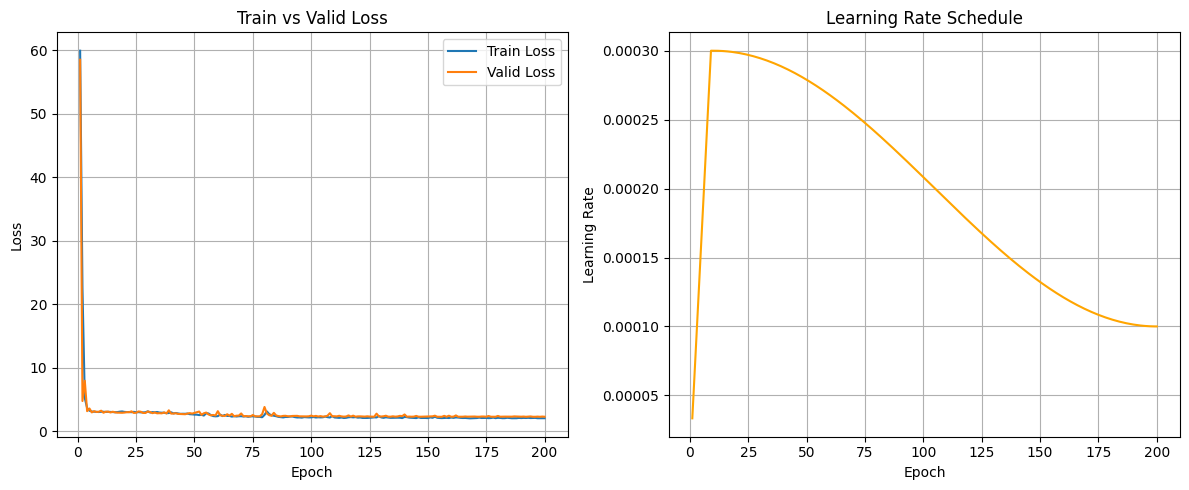

In [240]:
# Train/Validation loss 및 learning rate 시각화
plot_training_curves(train_losses, valid_losses, learning_rates)

### Test

In [243]:
test = pd.read_csv("C:/Users/user/Desktop/dacon_drug_development/dataset/test.csv")

In [244]:
# test dataset preprocessing
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)
test = test[test['Fingerprint'].notnull()]

test_features_df = pd.DataFrame([descriptors(s) for s in test['Smiles']])
test_final_dataset = pd.concat([test, test_features_df], axis=1)

[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerator
[16:22:18] DEPRECATION WARNING: please use MorganGenerat

In [245]:
# Data loading for test dataset
test_dataset = test_final_dataset.drop(['ID', 'Smiles'], axis=1)
test = CustomDataset(df=test_dataset, target=None, transform=transform, is_test=True)
test_loader = DataLoader(dataset=test, batch_size=CFG_model['BATCH_SIZE'], shuffle=False)

TypeError: CustomDataset.__init__() got an unexpected keyword argument 'df'

In [34]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs in test_loader:
            output = model(inputs)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [35]:
predictions = inference(test_loader, model_train)

In [37]:
# 앙상블을 위한 예측값 저장
np.save('mlp_test_preds.npy', np.array(predictions))

### Submission

In [66]:
submission = pd.read_csv('C:/Users/user/Desktop/dacon_drug_development/sample_submission.csv')

In [67]:
submission['ASK1_IC50_nM'] = predictions
submission

,ID,ASK1_IC50_nM
0,TEST_000,7.721341
1,TEST_001,8.064745
2,TEST_002,8.064745
3,TEST_003,8.920509
4,TEST_004,8.043378
...,...,...
122,TEST_122,7.592264
123,TEST_123,7.878330
124,TEST_124,7.723281
125,TEST_125,8.145455


In [68]:
submission.to_csv('C:/Users/user/Desktop/dacon_drug_development/MLP_2_submission.csv', index=False)